In [60]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated
from IPython.display import Image
import operator
from dotenv import load_dotenv
import os

load_dotenv()
strmodel = ChatOpenAI(model=os.getenv("strgpt_model"))

In [61]:
class eval(BaseModel):

    feedback: str = Field(description="detailed feedback of review")
    score: int = Field(description="give score out of 10", ge=0, le=10)
structure_model = strmodel.with_structured_output(eval)

In [62]:
class get_feedback(TypedDict):
    review: str
    
    Equipment_Facilities: str
    Cleanliness_Hygiene: str
    Crowd_Environment: str
    overall_feedback_for_gym: str
    individual_score: Annotated[list[int], operator.add]
    overall_score: float


In [63]:
def get_Equipment_Facilities_feedback(State:get_feedback):
    task = f"""
    you are an assistent for a gym review and you need to evaluate Equipment and Facilities feedback from client here
    and assign a score out of 10\n
    {State['review']} 
    """
    task_output = structure_model.invoke(task)
    return {'Equipment_Facilities':task_output.feedback,'individual_score':[task_output.score]}

def get_Cleanliness_Hygiene_feedback(State:get_feedback):
    task = f"""
    you are an assistent for a gym review and you need to evaluate Cleanliness and Hygiene feedback from client here
    and assign a score out of 10\n
    {State['review']} 
    """
    task_output = structure_model.invoke(task)
    return {'Cleanliness_Hygiene':task_output.feedback,'individual_score':[task_output.score]}

def get_Crowd_Environment_feedback(State:get_feedback):
    task = f"""
    you are an assistent for a gym review and you need to evaluate Crowd and Environment feedback from client here
    and assign a score out of 10\n
    {State['review']} 
    """
    task_output = structure_model.invoke(task)
    return {'Crowd_Environment':task_output.feedback,'individual_score':[task_output.score]}


In [64]:
def get_overall_feedback_for_gym_feedback(State:get_feedback):
    task = f"""
    based on the following feedback from Equipment andFacilities Agent\n
    {State['Equipment_Facilities']}
    Cleanliness and Hygiene Agent\n
    {State['Cleanliness_Hygiene']}
    Crowd and Environment Agent\n
    {State['Crowd_Environment']}
    \n
    create a summarized feedback 
    """
    task_output = strmodel.invoke(task)
    overall_score = sum(State['individual_score'])/len(State['individual_score'])
    return {'overall_feedback_for_gym':task_output.content,'overall_score':overall_score}

In [65]:
graph = StateGraph(get_feedback)

graph.add_node('get_Equipment_Facilities_feedback',get_Equipment_Facilities_feedback)
graph.add_node('get_Cleanliness_Hygiene_feedback',get_Cleanliness_Hygiene_feedback)
graph.add_node('get_Crowd_Environment_feedback',get_Crowd_Environment_feedback)
graph.add_node('get_overall_feedback_for_gym_feedback',get_overall_feedback_for_gym_feedback)

# edges
graph.add_edge(START,'get_Equipment_Facilities_feedback')
graph.add_edge(START,'get_Cleanliness_Hygiene_feedback')
graph.add_edge(START,'get_Crowd_Environment_feedback')

graph.add_edge('get_Equipment_Facilities_feedback','get_overall_feedback_for_gym_feedback')
graph.add_edge('get_Cleanliness_Hygiene_feedback','get_overall_feedback_for_gym_feedback')
graph.add_edge('get_Crowd_Environment_feedback','get_overall_feedback_for_gym_feedback')

graph.add_edge('get_overall_feedback_for_gym_feedback',END)

workflow = graph.compile()

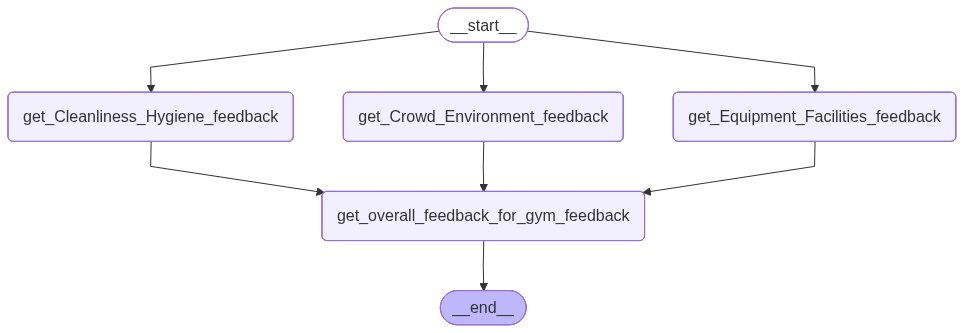

In [66]:
Image(workflow.get_graph().draw_mermaid_png())

In [ ]:
gym_review = """I've been going to this gym for about 3 months now and overall it's a great place to work out. 
The equipment is modern and well maintained, and there's rarely any downtime waiting for machines, even during peak hours. 
The trainers are knowledgeable and always willing to help if you ask, especially when it comes to correcting form and suggesting workout plans.
The atmosphere is motivating and the crowd is mostly serious about fitness, which helps you stay focused. 
I also like that they keep the place pretty clean — the washrooms and changing areas are regularly sanitized.
That said, it does get a bit crowded in the evenings, and sometimes the music is way too loud. A few more benches and squat racks would make a big difference. 
The monthly fee is slightly on the higher side, but considering the quality of equipment and trainers, I think it's worth it.
Would definitely recommend it if you're serious about training and want a good environment to stay consistent."""

In [68]:
# execute
initial_state = {'review':gym_review}
reponse_state = workflow.invoke(initial_state)

In [69]:
reponse_state.keys()

dict_keys(['review', 'Equipment_Facilities', 'Cleanliness_Hygiene', 'Crowd_Environment', 'overall_feedback_for_gym', 'individual_score', 'overall_score'])

In [71]:
print(reponse_state['Equipment_Facilities'])

The review provides a comprehensive overview of the gym's equipment and facilities. It highlights the modern and well-maintained state of the equipment, which is crucial for a positive workout experience. The mention of sufficient availability even during peak hours is a significant plus, as it indicates that the gym is well-equipped to handle its clientele. The feedback about knowledgeable trainers adds value, as personalized guidance can greatly enhance the workout experience. The cleanliness of the gym also contributes positively to the overall environment.

However, the reviewer points out some concerns, such as evening crowding and excessively loud music, which can detract from the experience. The request for additional benches and squat racks indicates that while the gym is equipped well, there is room for improvement in terms of space and availability of specific equipment. Finally, while the management of the facility and quality of services justify the high monthly fee, the re

In [72]:
print(reponse_state['Cleanliness_Hygiene'])

The client expresses a positive sentiment towards the cleanliness and hygiene of the gym, noting that the washrooms and changing areas are regularly sanitized. This indicates a strong commitment to maintaining a hygienic environment. Additionally, the mention of well-maintained and modern equipment suggests that the gym prioritizes cleanliness in all areas, including the machines themselves. Overall, the feedback shows satisfaction with cleanliness, which is a crucial aspect for gym-goers. There are no negative comments regarding hygiene, making it clear that cleanliness is a strength of this facility.


In [73]:
print(reponse_state['Crowd_Environment'])

The review provides a comprehensive overview of the crowd and environment at the gym. The mention of modern equipment and low downtime during peak hours reflects well on the facility's capacity and management. The positive description of the trainers adds to the supportive environment for members, suggesting a collaborative and encouraging atmosphere. However, the crowded evenings and loud music detract from the overall experience, indicating that there are areas for improvement. The cleanliness and regular sanitization of the washrooms and changing areas contribute positively to the gym's environment.


In [74]:
print(reponse_state['overall_feedback_for_gym'])

The feedback on the gym provides a balanced overview of its strengths and areas for improvement. Key strengths include:

- **Modern and Well-Maintained Equipment**: The gym features contemporary equipment that is regularly sanitized, enhancing the overall workout experience.
- **Cleanliness and Hygiene**: There is a strong commitment to cleanliness, with regularly sanitized washrooms and changing areas noted as a significant positive.
- **Knowledgeable Trainers**: The presence of well-informed trainers contributes to a supportive and collaborative atmosphere for members.
- **Sufficient Equipment Availability**: The gym efficiently handles peak hours with minimal downtime, ensuring access to equipment.

However, there are some concerns:

- **Evening Crowding and Loud Music**: The gym can become crowded in the evenings, and excessive volume from music may detract from the experience for some users.
- **Equipment Availability**: The request for additional benches and squat racks suggests 

In [75]:
print(reponse_state['individual_score'])

[9, 8, 8]


In [76]:
print(reponse_state['overall_score'])

8.333333333333334
